In [1]:
import numpy as np
import pandas as pd
import random
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [2]:
attack_size = 0.05
fs_size = 0.15
selected_list = []
target_list = []

In [3]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)
df['item_id'] = df['item_id'] - 1
df['user_id'] = df['user_id'] - 1
df1 = df
random_attack_mean = df['rating'].mean()
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles['item_id']-=1
df = pd.merge(df,movie_titles,on='item_id')

In [4]:
df1['rating'] = df1['rating'] - 3

In [5]:
user_rating = pd.DataFrame(df.groupby('user_id')['rating'].mean())

In [6]:
ratings = pd.DataFrame(df.groupby('item_id')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('item_id')['rating'].count())
ratings.reset_index(inplace=True)

In [7]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()
df_matrix = np.zeros((n_users, n_items))
for line in df.itertuples():
    df_matrix[line[1], line[2]] = line[3]  

In [8]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df1, test_size=0.25,random_state = 101)
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1], line[2]] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1], line[2]] = line[3]

In [9]:
# ORIGINAL 
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = 1 -  pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = 1 - pairwise_distances(train_data_matrix.T, metric='cosine')

def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #print(mean_user_rating[:, np.newaxis])
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = ratings - mean_user_rating[:, np.newaxis]
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return sqrt(mean_squared_error(prediction, ground_truth))

print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))



User-based CF RMSE: 1.3254161873157155
Item-based CF RMSE: 1.3773641808147512


In [10]:
def update(attack_matrix):
    global rating_map
    global random_attack_mean
    attack_df = pd.DataFrame(attack_matrix,index=None)
    attack_df = attack_df.stack().reset_index()
    column_names = ['user_id','item_id','rating']
    attack_df.set_axis(axis=1,labels=column_names)
    attack_df = attack_df[attack_df['rating']>0]
    random_attack_mean = attack_df['rating'].mean()    
    ratings = pd.DataFrame(attack_df.groupby('item_id')['rating'].mean())
    ratings['num of ratings'] = pd.DataFrame(attack_df.groupby('item_id')['rating'].count())
    ratings.reset_index(inplace=True)
    rating_map = pd.DataFrame(ratings[['item_id','rating']])
    rating_map.set_index('item_id',inplace=True)    

In [11]:
def random_attack(percentage_profiles,fs,attack_purpose,isBandwagon,rating_matrix,x,y):
    global target_list
    global random_attack_mean    
    target_items = ratings[ratings['num of ratings']<x].sort_values('num of ratings',ascending = False).head(y)
    target_list = pd.Series.tolist(target_items['item_id'])
    temp_matrix = np.matrix.copy(rating_matrix)
    n_users = temp_matrix.shape[0]
    n_profiles = round(percentage_profiles*n_users)
    temp_matrix.resize((n_users+n_profiles,n_items))
    mean_rating = random_attack_mean
    fs_size = round(fs*n_items)
    for i in range(n_users,n_users+n_profiles):
        for j in range(fs_size):
            filler_index = random.randint(0,1681)
            if filler_index in target_list:
                j = j-1
            elif (isBandwagon ==1) and filler_index in selected_list:
                j = j-1
            else:
                temp_matrix[i,filler_index]=round(mean_rating)

    for i in range(n_users,n_users+n_profiles):
        for j in range(len(target_list)):
            if attack_purpose=='push':
                temp_matrix[i,target_list[j]]=5
            else:
                temp_matrix[i,target_list[j]]=1
    update(temp_matrix)
    return temp_matrix   

In [12]:
def average_attack(percentage_profiles,fs,attack_purpose,isBandwagon,rating_matrix,x,y):
    global target_list
    target_items = ratings[ratings['num of ratings']<x].sort_values('num of ratings',ascending = False).head(y)
    target_list = pd.Series.tolist(target_items['item_id'])
    temp_matrix = np.matrix.copy(rating_matrix)
    n_users = temp_matrix.shape[0]
    n_profiles = round(percentage_profiles*n_users)
    temp_matrix.resize((n_users+n_profiles,n_items))
    fs_size = round(fs*n_items)
    for i in range(n_users,n_users+n_profiles):
        for j in range(fs_size):
            filler_index = random.randint(0,1681)
            if filler_index in target_list:
                j = j-1
            elif (isBandwagon ==1) and filler_index in selected_list:
                j = j-1
            else:
                temp_matrix[i,filler_index]=  round(pd.Series.tolist(rating_map.loc[(filler_index)])[0]) 
                
    for i in range(n_users,n_users+n_profiles):
        for j in range(len(target_list)):
            if attack_purpose=='push':
                temp_matrix[i,target_list[j]]=5
            else:
                temp_matrix[i,target_list[j]]=1
    update(temp_matrix)
    return temp_matrix  

In [13]:
def bandwagon_attack(percentage_profiles,fs,attack_purpose,bandwagon_attack_type,rating_matrix,x,y):
    global selected_list
    selected_items_size = pd.Series.tolist(round((0.05*ratings.count())))
    selected_items = ratings.sort_values('num of ratings',ascending=False).head(int(selected_items_size[0]*3))
    selected_items = selected_items.sort_values('rating',ascending=False).head(int(selected_items_size[0]))
    selected_list = pd.Series.tolist(selected_items['item_id'])
    if bandwagon_attack_type == 'Average':
        bandwagon_attack_matrix = average_attack(percentage_profiles,fs,attack_purpose,1,rating_matrix,x,y)
    else:
        bandwagon_attack_matrix = random_attack(percentage_profiles,fs,attack_purpose,1,rating_matrix,x,y)    
    for i in range(n_users,bandwagon_attack_matrix.shape[0]):
        for j in selected_list:
            bandwagon_attack_matrix[i,j] = 5
    update(bandwagon_attack_matrix)
    return bandwagon_attack_matrix   

In [14]:
rating_map = pd.DataFrame(ratings[['item_id','rating']])
rating_map.set_index('item_id',inplace=True)

In [15]:
random_attack_matrix = random_attack(attack_size,fs_size,'push',0,df_matrix,150,20)

In [16]:
average_attack_matrix = average_attack(attack_size,fs_size,'push',0,df_matrix,150,20)

In [17]:
bandwagon_attack_matrix = bandwagon_attack(attack_size,fs_size,'push','Random',df_matrix,150,20)

In [18]:
def visualization(user_prediction_with_attack,item_prediction_with_attack):
    original_user_prediction_list = []
    for i in target_list:
        temp = []
        for j in range(n_users):
            temp.append(user_prediction[j,i])
        original_user_prediction_list.append(temp)
    attack_user_prediction_list = []
    for i in target_list:
        temp = []
        for j in range(n_users):
            temp.append(user_prediction_with_attack[j,i])
        attack_user_prediction_list.append(temp)
    original_item_prediction_list = []
    for i in target_list:
        temp = []
        for j in range(n_users):
            temp.append(item_prediction[j,i])
        original_item_prediction_list.append(temp)
    attack_item_prediction_list = []
    for i in target_list:
        temp = []
        for j in range(n_users):
            temp.append(item_prediction_with_attack[j,i])
        attack_item_prediction_list.append(temp)
    rmse_user_rattack = []
    for i in range(20):
        rmse_user_rattack.append(sqrt(mean_squared_error(original_user_prediction_list[i],attack_user_prediction_list[i])))
    rmse_item_rattack = []
    for i in range(20):
        rmse_item_rattack.append(sqrt(mean_squared_error(original_item_prediction_list[i],attack_item_prediction_list[i])))
    vis = pd.DataFrame(rmse_user_rattack,columns=['User-User CF'])
    vis['Item-Item CF']=rmse_item_rattack
    vis_matrix = np.zeros((20,2))
    for line in vis.itertuples():
        vis_matrix[line[0]][0] = line[1]
        vis_matrix[line[0]][1] = line[2]
    plt.figure(figsize=(12,4),)
    plt.hist(vis_matrix, histtype='bar', color=['Red','Green'], stacked=False, fill=True)
    plt.xlabel("RMSE Values",fontsize='xx-large')
    plt.ylabel("Number of target items",fontsize='xx-large')
    plt.title("Effect of Shilling Attack on CF models",fontsize='xx-large')
    plt.legend(['User-User CF','Item-Item CF'],fontsize='xx-large')
    plt.savefig('visual')

In [19]:
def error(attack_matrix,attack_type):
    attack_df = pd.DataFrame(attack_matrix,index=None)
    attack_df = attack_df.stack().reset_index()
    column_names = ['user_id','item_id','ratings']
    attack_df.set_axis(axis=1,labels=column_names)
    attack_df = attack_df[attack_df['ratings']>0]

    train_data_attack, test_data_attack = train_test_split(attack_df, test_size=0.25,random_state = 101)
    #Create two user-item matrices, one for training and another for testing
    attack_matrix_size = attack_matrix.shape
    train_data_matrix_attack = np.zeros((attack_matrix_size[0], attack_matrix_size[1]))
    for line in train_data.itertuples():
        train_data_matrix_attack[line[1], line[2]] = line[3] - 3
    test_data_matrix_attack = np.zeros((attack_matrix_size[0], attack_matrix_size[1]))
    for line in test_data.itertuples():
        test_data_matrix_attack[line[1], line[2]] = line[3] - 3

    user_similarity_attack = 1 - pairwise_distances(train_data_matrix_attack, metric='cosine')
    item_similarity_attack = 1 - pairwise_distances(train_data_matrix_attack.T, metric='cosine')
    item_prediction_with_attack = predict(train_data_matrix_attack, item_similarity_attack, type='item')
    user_prediction_with_attack = predict(train_data_matrix_attack, user_similarity_attack, type='user')
    visualization(user_prediction_with_attack,item_prediction_with_attack)
    print('User-based CF RMSE with '+ attack_type+": " + str(rmse(user_prediction_with_attack, test_data_matrix_attack)))
    print('Item-based CF RMSE with '+ attack_type + ": "+ str(rmse(item_prediction_with_attack, test_data_matrix_attack)))

In [20]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('Model Based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

Model Based CF MSE: 1.2669700050556207


In [21]:
def detection(attack_matrix,profile_threshold):
    df_temp = np.matrix.copy(attack_matrix)
    temp = pd.DataFrame(df_temp.T)
    temp.replace(to_replace=0.0,value=np.nan,inplace=True)
    corr_df = temp.corr() 
    shilling_list=[]
    for line in corr_df.itertuples():
        count = 0
        for i in range(1,attack_matrix.shape[0]):
            if line[i] >= 0.95:
                count+=1
        if count >= profile_threshold*df_matrix.shape[0]:
            shilling_list.append(line[0])
    return shilling_list

User-based CF RMSE with random: 2.283605884289169
Item-based CF RMSE with random: 2.368058219517133


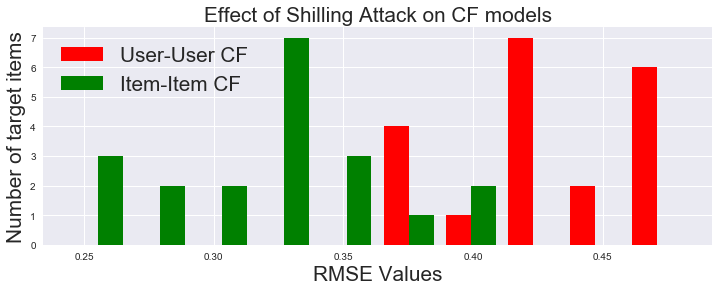

In [22]:
error(random_attack_matrix,"random")

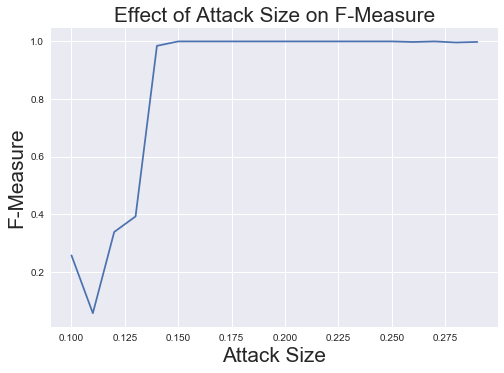

In [23]:
attack_size = 0.1
attack_sizes = []
f_scores = []
def f_measure():
    global attack_size
    for i in range(20):
        x = 0.15
        temp_random_attack = random_attack(attack_size,fs_size,'push',0,df_matrix,150,20)
        temp_shilling_list = detection(temp_random_attack,x)
        while(True):
            x-=0.01
            temp_shilling_list = detection(temp_random_attack,x)
            if (not(len(temp_shilling_list)==0)):
                break
        count = 0
        for i in temp_shilling_list:
            if i>=944:
                count+=1
        if(not(count==0)):
            precision = count/len(temp_shilling_list)
            recall = count/round(attack_size * df_matrix.shape[0])
            f_score = 2*precision*recall/(precision+recall)
            f_scores.append(f_score)
            attack_sizes.append(attack_size)
        else:
            f_scores.append(0)
            attack_sizes.append(attack_size)
        attack_size+=0.01

f_measure()
analysis = pd.DataFrame(attack_sizes,columns=["Attack_Size"])
analysis["F_Score"] = f_scores
plt.plot(attack_sizes,f_scores)
plt.xlabel("Attack Size",fontsize='xx-large')
plt.ylabel("F-Measure",fontsize='xx-large')
plt.title("Effect of Attack Size on F-Measure",fontsize='xx-large')